## Exploring Data





### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import shutil
import random
from cv2 import imread
import time

### Define working paths

In [ ]:
train_path = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_path = '/kaggle/input/intel-image-classification/seg_test/seg_test'
pred_path = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

In [ ]:
print('training categories : {} '.format(len(os.listdir(train_path))))
print('testing categories : {} '.format(len(os.listdir(test_path))))
print('pred samples : {} '.format(len(os.listdir(pred_path))))

training categories : 6 
testing categories : 6 
pred samples : 7301 


### Dataset stats

In [ ]:
def print_stats(path = ''):
    l =  []
    for class_name in os.listdir(path):
        print("{} : {} images".format(class_name,len(os.listdir(path + '/' + class_name))))
        l.append(len(os.listdir(path + '/' + class_name)))
        
    print("{} CLASSES".format(len(l)))        
    print("TOTAL SIZE = {}".format(sum(l)))    

In [ ]:
print("*********************")
print("TRAIN DATA STATS")

print_stats(path = train_path)

print("*********************")
print("TEST DATA STATS")

print_stats(path = test_path)

print("*********************")


*********************
TRAIN DATA STATS
mountain : 2512 images
street : 2382 images
buildings : 2191 images
sea : 2274 images
forest : 2271 images
glacier : 2404 images
6 CLASSES
TOTAL SIZE = 14034
*********************
TEST DATA STATS
mountain : 525 images
street : 501 images
buildings : 437 images
sea : 510 images
forest : 474 images
glacier : 553 images
6 CLASSES
TOTAL SIZE = 3000
*********************


In [ ]:
def extract_corrupt_img_files(dir_path='' ,verbose = True):
  """
  Gets corrupted image files within a directory
  
    Arguments:
        dir_path: a string representing the path for the target directory

    Returns:
        a list of the paths for the corrupted image files

  """ 
  i = 0
  beg = time.time()
  corrupted = []
  for filename in os.listdir(dir_path):
    i +=1
    if verbose == True:
        if (i % 50 == 0):
          print(i, end =" ")
        if (i % 1000 == 0):
          print()
    try:
      img = Image.open(dir_path + '/' + filename)
    except:
      corrupted.append(dir_path + '/' + filename)
      continue

  end = time.time()
  print()
  print('*' * 50) 
  print("\nTASK FINISHED IN " + str(end - beg) + " seconds ")
  print("{} corrupted files found in {}".format(len(corrupted), dir_path))
  print(corrupted)
  print()
  print('*' * 50) 
  return corrupted

In [ ]:
corrupted = []
for path in [test_path, train_path]:
    for class_name in os.listdir(path):
        l = extract_corrupt_img_files(path + '/' + class_name)
        corrupted = corrupted + l

print(len(corrupted))
print(corrupted)


50 100 150 200 250 300 350 400 450 500 
**************************************************

TASK FINISHED IN 2.423187255859375 seconds 
0 corrupted files found in /kaggle/input/intel-image-classification/seg_test/seg_test/mountain
[]

**************************************************
50 100 150 200 250 300 350 400 450 500 
**************************************************

TASK FINISHED IN 2.49489426612854 seconds 
0 corrupted files found in /kaggle/input/intel-image-classification/seg_test/seg_test/street
[]

**************************************************
50 100 150 200 250 300 350 400 
**************************************************

TASK FINISHED IN 2.0568313598632812 seconds 
0 corrupted files found in /kaggle/input/intel-image-classification/seg_test/seg_test/buildings
[]

**************************************************
50 100 150 200 250 300 350 400 450 500 
**************************************************

TASK FINISHED IN 2.4716882705688477 seconds 
0 corrupted fi

In [ ]:
def visualize_samples(path ='', ncols = 1, nrows = 1, fig_size = (7,4), title =""):
    fig = plt.figure(figsize = fig_size)
    
    i = 0
    for filename in (random.sample(os.listdir(path), ncols * nrows)):
        img = imread(path + '/' + filename)
        fig.add_subplot(nrows, ncols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        i+=1
        
    
    plt.tight_layout()
    plt.suptitle(title)

    


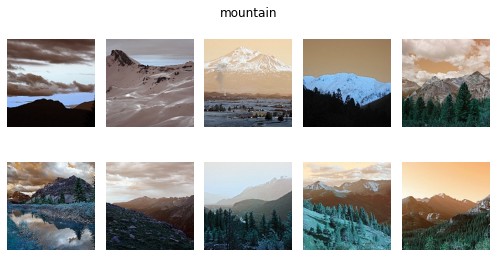

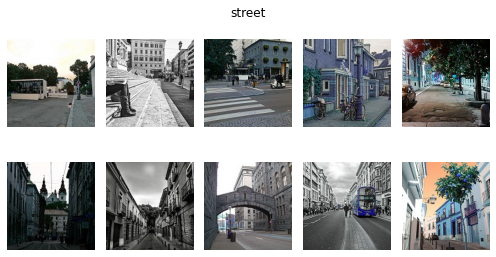

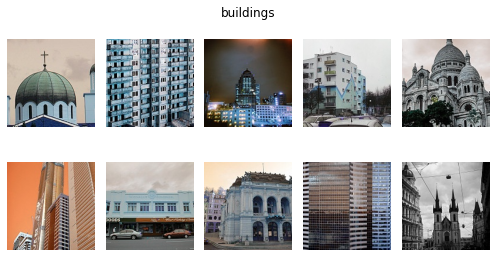

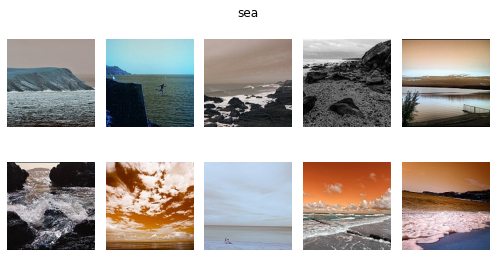

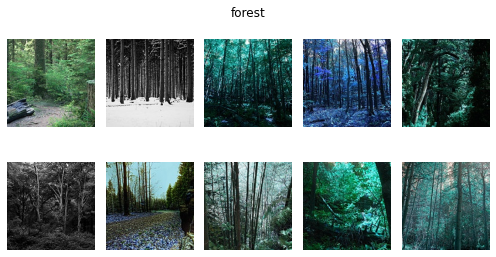

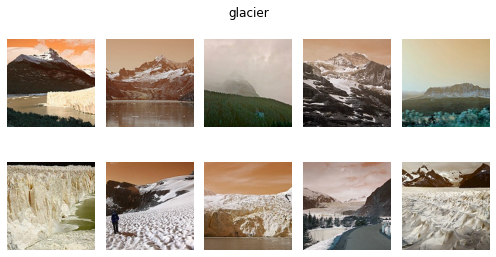

In [ ]:
for class_name in os.listdir(train_path):
    visualize_samples(train_path + '/' + class_name
                      ,5,2, title = class_name)

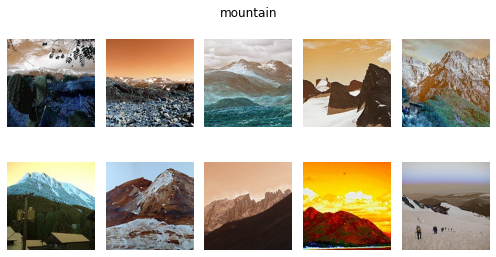

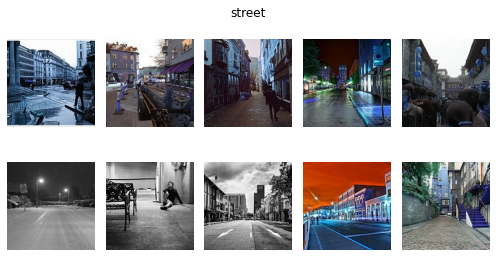

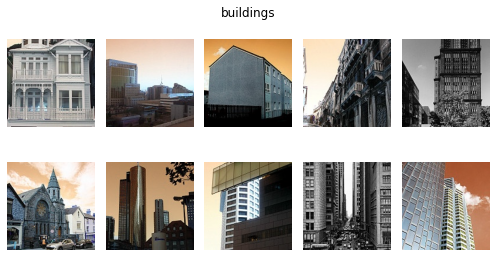

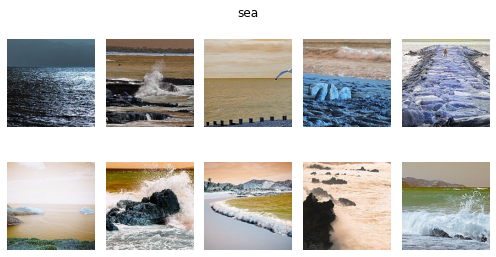

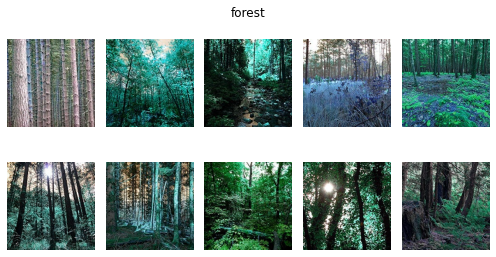

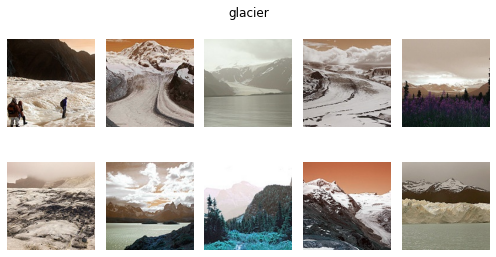

In [ ]:
for class_name in os.listdir(test_path):
    visualize_samples(test_path + '/' + class_name
                      ,5,2, title = class_name)

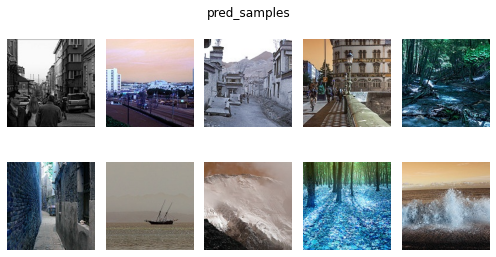

In [ ]:
visualize_samples(pred_path 
                      ,5,2, title = "pred_samples")

In [ ]:
IMG_SIZE = (150,150,3)

# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(

    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9,1.1),
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
print("train generator :", end ='')
train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=1,
    subset='training'
)

print("validation generator :", end ='')
validation_generator = train_datagen.flow_from_directory(
    directory = train_path,
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=1,
    subset='validation'
)

print("test generator :" , end ='')
test_generator = test_datagen.flow_from_directory(    
    directory = test_path,
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=1
)

train generator :Found 11230 images belonging to 6 classes.
validation generator :Found 2804 images belonging to 6 classes.
test generator :Found 3000 images belonging to 6 classes.


# Building the network

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2023-01-16 11:00:55.185769: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0

# Training the network

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau , CSVLogger
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience= 4, 
                                            verbose= 1, 
                                            factor= 0.5, 
                                            min_lr= 0.00001)

early_stopping = EarlyStopping(patience = 7)


checkpoint_acc = ModelCheckpoint(filepath =  '/kaggle/working/model_best_acc.hdf5',
    monitor = "val_accuracy",
    save_best_only = True, save_freq= 'epoch' )

filename='log.csv'
history_logger= CSVLogger(filename, separator=",", append=True)


callbacks = [learning_rate_reduction, early_stopping  , 
             checkpoint_acc, history_logger]

In [ ]:
EPOCHS = 40
beg = int(time.time())

history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples  // 32,
        epochs = EPOCHS,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // 32,
        callbacks = callbacks)

end = int(time.time())
t = end - beg
hrs = t // 3600
mins = (t - 3600 * hrs) // 60
secs = t % 60
print("training took {} hrs -- {} mins -- {} secs".format(hrs,mins,secs))
model.save_weights('/CNN_first_try_weights.h5')
model.save( '/CNN_first_try.h5')

2023-01-16 00:35:22.652810: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
350/350 [==============================] - 306s 869ms/step - loss: 1.0778 - accuracy: 0.6163 - val_loss: 5.7404 - val_accuracy: 0.2098
Epoch 2/40
350/350 [==============================] - 304s 868ms/step - loss: 0.7772 - accuracy: 0.7162 - val_loss: 1.1185 - val_accuracy: 0.6034
Epoch 3/40
350/350 [==============================] - 301s 860ms/step - loss: 0.6807 - accuracy: 0.7511 - val_loss: 0.6777 - val_accuracy: 0.7428
Epoch 4/40
350/350 [==============================] - 302s 862ms/step - loss: 0.6039 - accuracy: 0.7834 - val_loss: 0.9372 - val_accuracy: 0.7428
Epoch 5/40
350/350 [==============================] - 304s 867ms/step - loss: 0.5694 - accuracy: 0.7946 - val_loss: 0.7201 - val_accuracy: 0.7629
Epoch 6/40
350/350 [==============================] - 303s 866ms/step - loss: 0.5343 - accuracy: 0.8077 - val_loss: 0.8173 - val_accuracy: 0.6897
Epoch 7/40
350/350 [==============================] - 303s 865ms/step - loss: 0.5110 - accuracy: 0.8155 - val_loss: 1.5942 -

# Model Evaluation

In [ ]:
scores = model.evaluate(test_generator)

94/94 [==============================] - 19s 201ms/step - loss: 0.3790 - accuracy: 0.8833


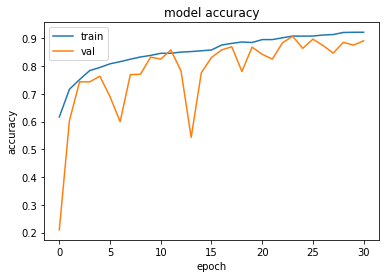

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

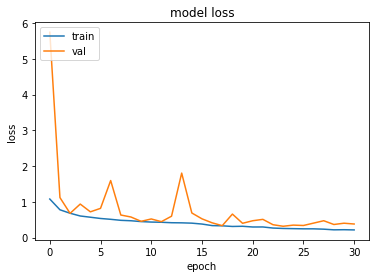

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_generator)

94/94 [==============================] - 19s 198ms/step - loss: 0.4128 - accuracy: 0.8693


Checkpoint accuracy of **89.47%**

In [ ]:

model.load_weights('/kaggle/working/model_best_acc.hdf5')
score = model.evaluate(test_generator)
print(score)



94/94 [==============================] - 18s 196ms/step - loss: 0.3250 - accuracy: 0.8947
[0.32501673698425293, 0.8946666717529297]


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
EPOCHS = 10
beg = int(time.time())

history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples  // 32,
        epochs = EPOCHS,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // 32,
        callbacks = callbacks)

end = int(time.time())
t = end - beg
hrs = t // 3600
mins = (t - 3600 * hrs) // 60
secs = t % 60
print("training took {} hrs -- {} mins -- {} secs".format(hrs,mins,secs))
model.save_weights('/kaggle/working/CNN_second_try_weights.h5')
model.save( '/kaggle/working/CNN_second_try.h5')

Epoch 1/10
350/350 [==============================] - 303s 864ms/step - loss: 0.2284 - accuracy: 0.9172 - val_loss: 0.3776 - val_accuracy: 0.8836
Epoch 2/10
350/350 [==============================] - 303s 865ms/step - loss: 0.2377 - accuracy: 0.9128 - val_loss: 0.5107 - val_accuracy: 0.8348
Epoch 3/10
350/350 [==============================] - 302s 863ms/step - loss: 0.2363 - accuracy: 0.9134 - val_loss: 0.3443 - val_accuracy: 0.8693
Epoch 4/10
350/350 [==============================] - 302s 863ms/step - loss: 0.2244 - accuracy: 0.9185 - val_loss: 0.3324 - val_accuracy: 0.8908
Epoch 5/10
350/350 [==============================] - 303s 865ms/step - loss: 0.2206 - accuracy: 0.9212 - val_loss: 0.4501 - val_accuracy: 0.8635
Epoch 6/10
350/350 [==============================] - 302s 863ms/step - loss: 0.2161 - accuracy: 0.9214 - val_loss: 0.4509 - val_accuracy: 0.8520
Epoch 7/10
350/350 [==============================] - 299s 853ms/step - loss: 0.2032 - accuracy: 0.9245 - val_loss: 0.4334 -

The final test accuracy is **89.47%**

In [ ]:
model.load_weights('/kaggle/working/model_best_acc.hdf5')
score = model.evaluate(test_generator)
print(score)


94/94 [==============================] - 19s 197ms/step - loss: 0.3250 - accuracy: 0.8947
[0.32501673698425293, 0.8946666717529297]
